# Experimental Evaluation

MIFE scheme, we used ElGamal as the public-key encryption scheme

This notebook was runned with a HP Laptop 14s-dq1xxx with a 1GHz Intel Core i5 and 8GB RAM running Windows 10, 64 bit and Python 3.10 using `PyCryptoDome` and `numpy`

We first begin by generating some 1024 bit $G, P$ parameters that will be recycled for the whole experiment, since it is the most time consuming operation

In [1]:
from utils import generate_gp

LOAD_GP = True

if LOAD_GP: 
    # loading the generated values
    with open('gp.txt', 'r') as f:
        G = int(f.readline().split('=')[1])
        P = int(f.readline().split('=')[1])
else:
    G, P = generate_gp(nbits=1024, num_processes=8)
    print("G =", G)
    print("P =", P) 
    # saving the generated values
    with open('gp.txt', 'w') as f:
        f.write("G = " + str(G) + "\n")
        f.write("P = " + str(P) + "\n")

After this we proceed to show an initial representation of the tree, and the following operations

1. **Tree generation and population**: The tree nodes are initialized depending on the $N$ value and a dataset is added
2. **Noise addition**: Noise is added to each node
3. **Encryption**: Each node is encypted. Note that the result of *ElGamal* encryption gives two large values of which only the first two digits are represented in the tree

Num_leaves: 16, Num_nodes: 31


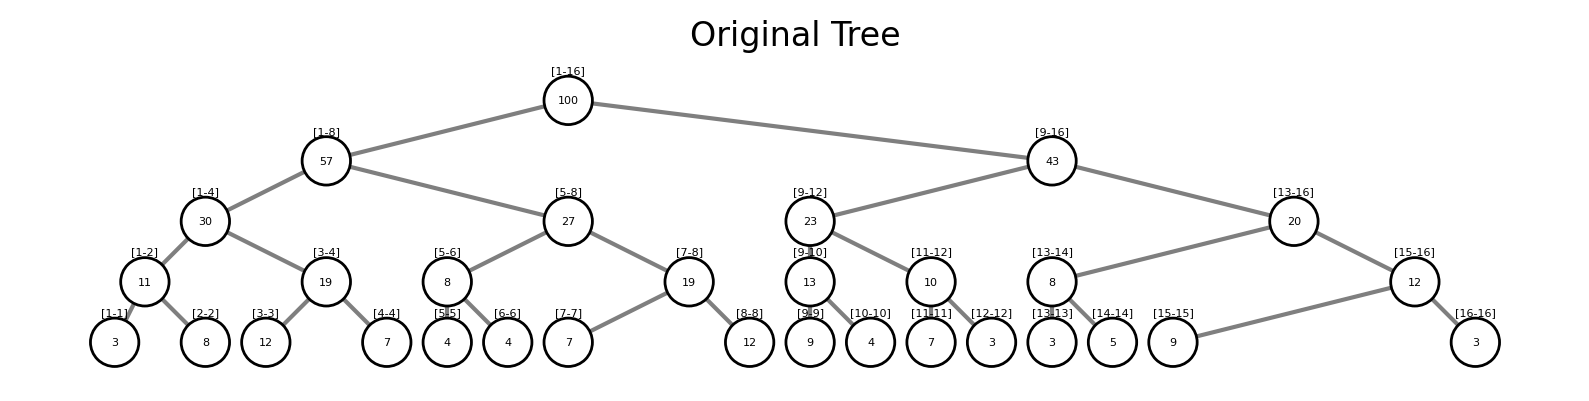

Query [14, 15]: 14


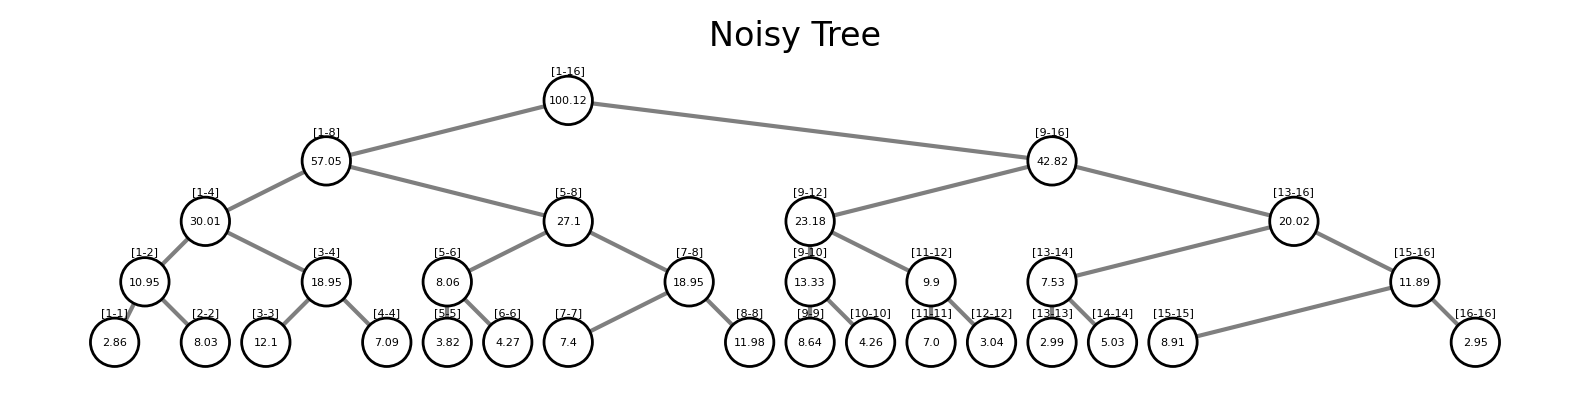

Query [14, 15]: 13.94263360959636


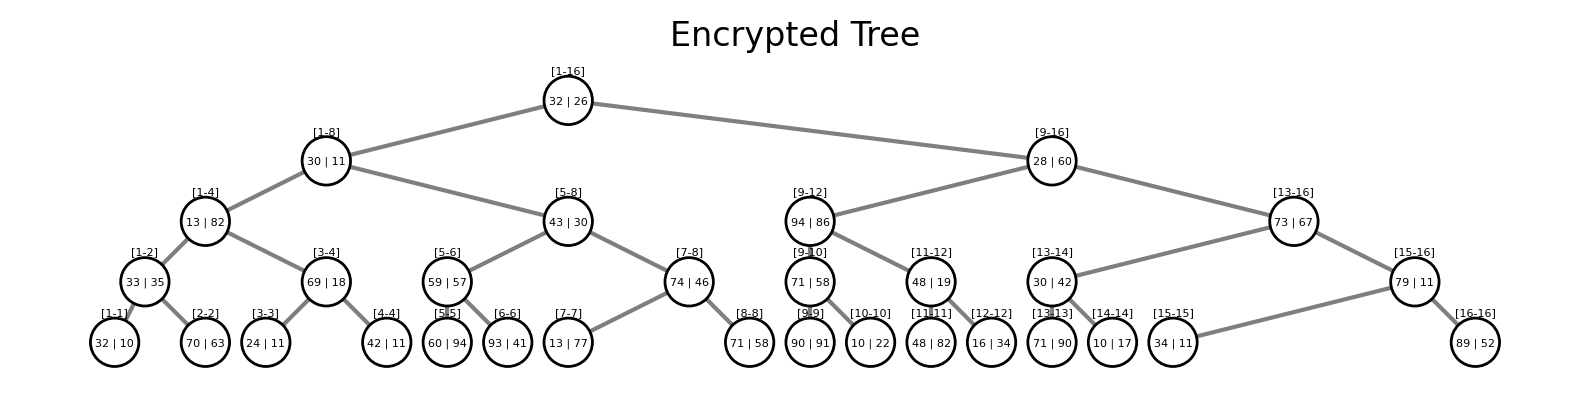

Query [14, 15]: 13
Query [14, 15]: 13
{'generateAndPopulate': 0.000359599944204092, 'generateKeys': 0.47487902641296387, 'addNoise': 7.329997606575489e-05, 'encrypt': 0.3479654788970947}


In [4]:
import random
import math
import numpy as np
from mife import MIFE, ElGamal
from utils import *
from plm import PLM_H
from entities import BinaryRangeTree, Curator
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['figure.dpi'] = 200


N = 4
DATASET_SIZE = 100

print(f"Num_leaves: {2**N}, Num_nodes: {2**(N+1)-1}")

x = np.random.randint(1, 2**N+1, DATASET_SIZE)
C = Curator(N, x, G=G, P=P)
query = random.randint(1, 2**N-1)
query = [query, random.randint(query+1, 2**N)]
plot_tree(C.T, "Original Tree")
print(f"Query {query}: {C.read(query)}")
C.add_noise(10)
plot_tree(C.T, "Noisy Tree")
print(f"Query {query}: {C.read(query)}")
C.encrypt()
plot_tree(C.T, "Encrypted Tree")
print(f"Query {query}: {C.read(query)}")
print(f"Query {query}: {C.read(query, f_key=True)}")
print(C.times)
# print(C.mife.dec_l1(C.T.get_values()))

In [5]:
import pandas as pd

N_values = range(5, 11)
Dataset_Sizes = [100, 500, 1000, 10000]

df1 = pd.DataFrame(columns=['Dataset Size', 'Number of Leaves', 'Time (ms)'])
df2 = pd.DataFrame(columns=['Total Number of Tree Nodes', 'Laplacian Noise', 'Key Generation', 'Encryption', 'Tree Generation(Dataset size = 10000)', 'Total Time'])

for dataset_size in Dataset_Sizes:
    for N in N_values:
        x = np.random.randint(1, 2**N, dataset_size)
        C = Curator(N, x, G=G, P=P)
        C.add_noise(10)
        C.encrypt()
        df1 = pd.concat([df1, pd.DataFrame({'Dataset Size': [dataset_size], 'Number of Leaves': [2**N], 'Time (ms)': [C.times["generateAndPopulate"]*1000]})], ignore_index=True)
        if dataset_size == 10000:
            df2 = pd.concat([df2, pd.DataFrame({'Total Number of Tree Nodes': [2**(N+1)-1], 'Laplacian Noise': [C.times["addNoise"]], 'Key Generation': [C.times["generateKeys"]], 'Encryption': [C.times["encrypt"]],'Tree Generation(Dataset size = 10000)': [C.times["generateAndPopulate"]], 'Total Time': [sum(C.times.values())]})], ignore_index=True)
        print(N, dataset_size, C.times)

# save to excel
df1.to_excel("cw2_1.xlsx")
df2.to_excel("cw2_2.xlsx")

5 100 {'generateAndPopulate': 0.000776599976234138, 'generateKeys': 0.9124290943145752, 'addNoise': 0.0002250999677926302, 'encrypt': 0.6044976711273193}
6 100 {'generateAndPopulate': 0.0003992000129073858, 'generateKeys': 2.2853572368621826, 'addNoise': 0.00025939999613910913, 'encrypt': 1.2811272144317627}
7 100 {'generateAndPopulate': 0.0005083000287413597, 'generateKeys': 4.28671669960022, 'addNoise': 0.0005538999103009701, 'encrypt': 3.154409170150757}
8 100 {'generateAndPopulate': 0.0008008000440895557, 'generateKeys': 8.78896164894104, 'addNoise': 0.0008391999872401357, 'encrypt': 4.865489482879639}
9 100 {'generateAndPopulate': 0.0011509000323712826, 'generateKeys': 15.160267114639282, 'addNoise': 0.0015648000407963991, 'encrypt': 9.768162488937378}
10 100 {'generateAndPopulate': 0.0028472000267356634, 'generateKeys': 32.30769157409668, 'addNoise': 0.0031905999640002847, 'encrypt': 19.56118869781494}
5 500 {'generateAndPopulate': 0.0014405000256374478, 'generateKeys': 0.9166383

In [6]:
# show the table
df1

,Dataset Size,Number of Leaves,Time (ms)
0,100,32,0.7766
1,100,64,0.3992
2,100,128,0.5083
3,100,256,0.8008
4,100,512,1.1509
5,100,1024,2.8472
6,500,32,1.4405
7,500,64,1.7577
8,500,128,3.3228
9,500,256,2.1965


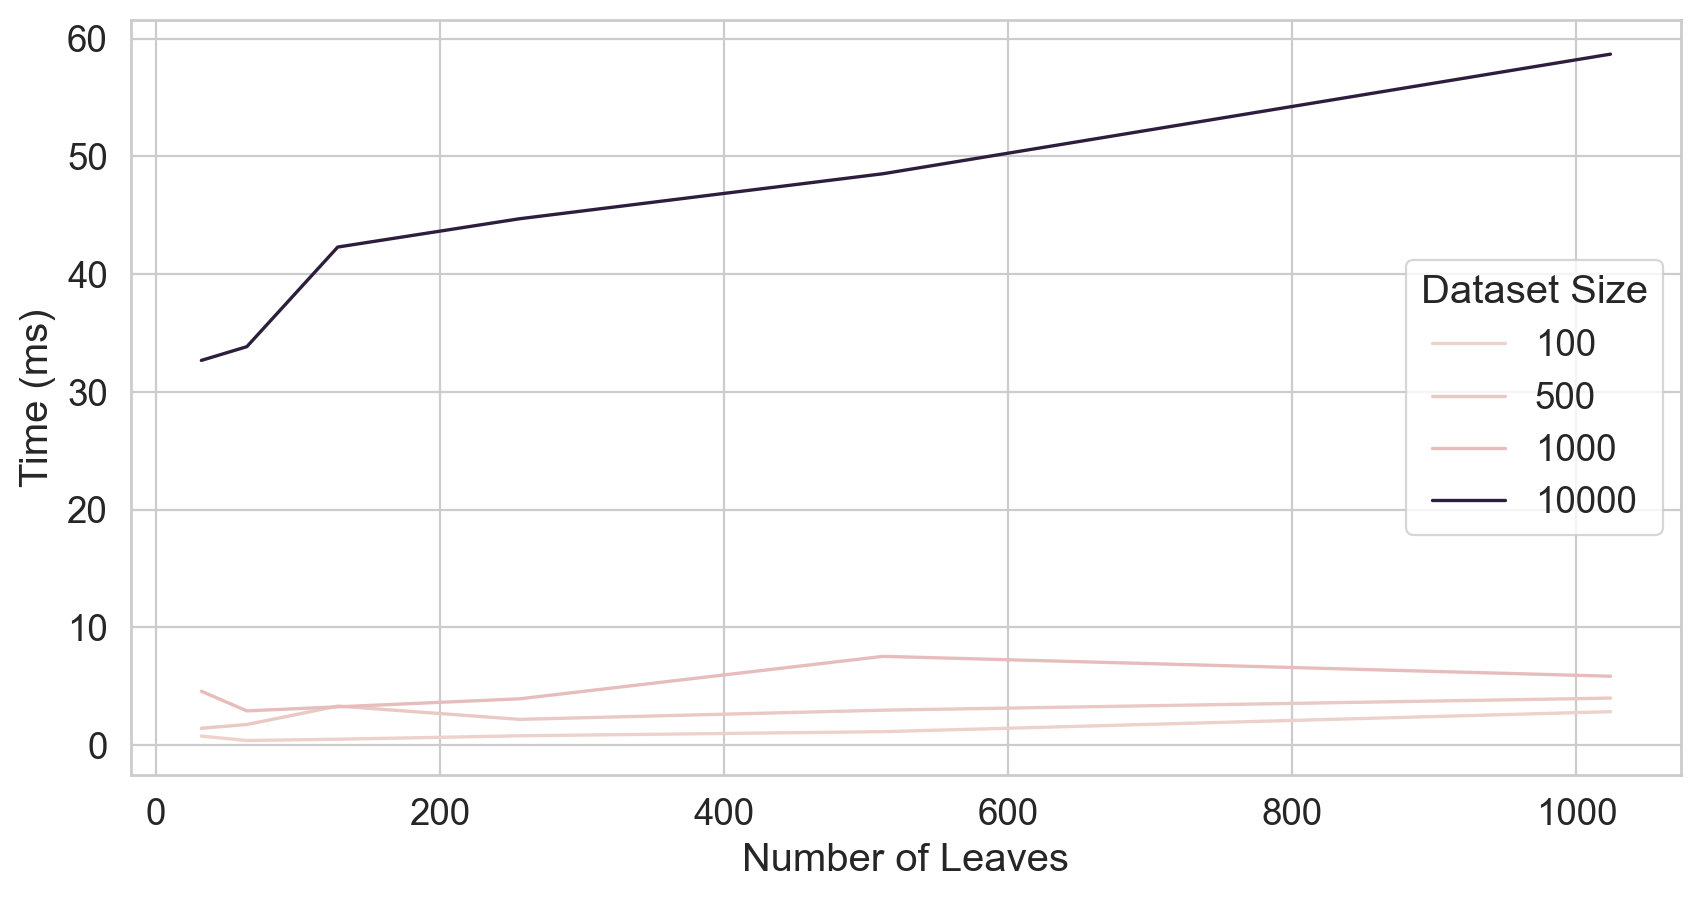

In [7]:
# draw the graph number of leaves vs time as a graph and points
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(10, 5))
ax = sns.lineplot(x="Number of Leaves", y="Time (ms)", hue="Dataset Size", data=df1)



In [8]:
df2

,Total Number of Tree Nodes,Laplacian Noise,Key Generation,Encryption,Tree Generation(Dataset size = 10000),Total Time
0,63,0.000123,0.981824,0.651019,0.032682,1.665648
1,127,0.000229,1.927039,1.285610,0.033847,3.246724
2,255,0.000717,3.833194,2.742809,0.042308,6.619028
3,511,0.000816,7.640293,5.228642,0.044711,12.914462
4,1023,0.001535,15.511828,9.752082,0.048536,25.313982
5,2047,0.003301,31.887737,19.577170,0.058690,51.526899


Finally we capture a, fully unrealistic/worst-case scenario, retrieve the values from all the leaves of a 1024 leaves tree

In [9]:
import time

N = 10

x = np.random.randint(1, 2**N, 10000)
C = Curator(N, x, G=G, P=P)
interval = (10, 16)
interval = (interval, C.read(interval))
C.encrypt()
t0 = time.perf_counter()
checksum = sum([C.T.query_interval([i, i]) for i in range(1, 2**N+1)])
if checksum == 10000:
    print("Time to retrieve all leaves: ", round(time.perf_counter() - t0, 5)*1000, "ms", sep="")
else:
    print("Error", time.time() - t0)

print(f"Query {interval[0]}: {interval[1]}")
t0 = time.perf_counter()
checksum = C.read(interval[0])
print(f"Time to retrieve interval: {round(1000*(time.perf_counter() - t0), 2)}ms, checksum: {checksum}")
t0 = time.perf_counter()
checksum = C.read((interval[0]), f_key=True)
print(f"Time to retrieve interval with functional key: {round(1000*(time.perf_counter() - t0), 2)}ms, checksum: {checksum}")

Time to retrieve all leaves: 281.37ms
Query (10, 16): 59
Time to retrieve interval: 1.42ms, checksum: 59
Time to retrieve interval with functional key: 1.59ms, checksum: 59


In [11]:
from mife import ElGamal
from utils import generate_gp, enc_gamal_additive, dec_gamal_additive
import random
import numpy as np

G, P = generate_gp(nbits=8, num_processes=8)
r = random.randint(1, P-1)

m1, m2 = random.randint(1, int((P-1)/4)), random.randint(1, int((P-1)/4))
print(f"{m1} + {m2} = {m1+m2}")

eg1 = ElGamal(nbits=8, G=G, P=P)
eg2 = ElGamal(nbits=8, G=G, P=P)

c_1 = np.prod([eg1.enc(m1, "additive"), eg2.enc(m2, "additive")], axis=0).tolist()
c_1 = c_1[0]%P, c_1[1]%P
c_2 = enc_gamal_additive(m1 + m2, eg1.pk*eg2.pk, G, P)

print(c_1, c_2)
d1 = dec_gamal_additive(c_1, eg2.sk, G, P)
d2 = dec_gamal_additive(c_2, eg1.sk + eg2.sk, G, P)
d3 = dec_gamal_additive(c_1, eg1.sk + eg2.sk, G, P)
print(d1, d2, d3)


27 + 18 = 45
(100, 13) (100, 46)
45 45 71
